In [40]:
!pip install xgboost scikit-learn torch matplotlib seaborn

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/18/cf/ae99bd066571656185be0d88ee70abc58467b76f2f7c8bfeb48735a71fe6/torch-2.6.0-cp312-cp312-win_amd64.whl.metadata
  Using cached torch-2.6.0-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/44/4b/e0cfc1a6f17e990f3e64b7d941ddc4acdc7b19d6edd51abf495f32b1a9e4/fsspec-2025.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (1


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import pandas as pd


# read csv file
df = pd.read_csv("datasets/hurdat2_bayesian_inference_shelters.csv")

In [78]:
df.head()

,storm_id,maximum_sustained_wind_knots_mean,maximum_sustained_wind_knots_max,central_pressure_mb_mean,central_pressure_mb_min,radius_of_max_wind_nm_mean,radius_of_max_wind_nm_max,maximum_sustained_wind_knots_max_norm,maximum_sustained_wind_knots_mean_norm,central_pressure_mb_min_norm,...,model5991,model5992,model5993,model5994,model5995,model5996,model5997,model5998,model5999,model6000
0,AL011915,52.142857,65,996.5,990,15.0,15,-2.346186,-1.514785,2.496747,...,36.342368,17.541936,2.973393,40.607240,19.633834,8.192459e+00,0.351957,29.282892,1.725364e+00,4.710389
1,AL011926,70.000000,90,967.0,967,15.0,15,-1.173093,-0.776530,1.304211,...,61.945606,37.343828,0.267933,91.318455,16.581257,2.594741e-02,0.005879,8.899177,1.513615e+02,0.150005
2,AL011928,50.666667,90,977.0,977,10.0,10,-1.173093,-1.575815,1.822705,...,34.122793,6.014419,8.948522,0.000817,0.226182,2.230243e-37,6.097859,79.914809,5.823549e-161,131.654280
3,AL011966,76.666667,90,975.5,970,30.0,30,-1.173093,-0.500915,1.459759,...,60.734628,59.261792,44.641342,288.351208,40.432212,3.091178e+01,54.839736,60.995281,1.053848e+02,126.914516
4,AL021899,65.625000,85,979.0,979,10.0,10,-1.407711,-0.957403,1.926404,...,62.690053,28.730202,10.896949,46.933258,15.061314,6.305638e+01,75.609026,160.243193,8.065322e-02,0.541238


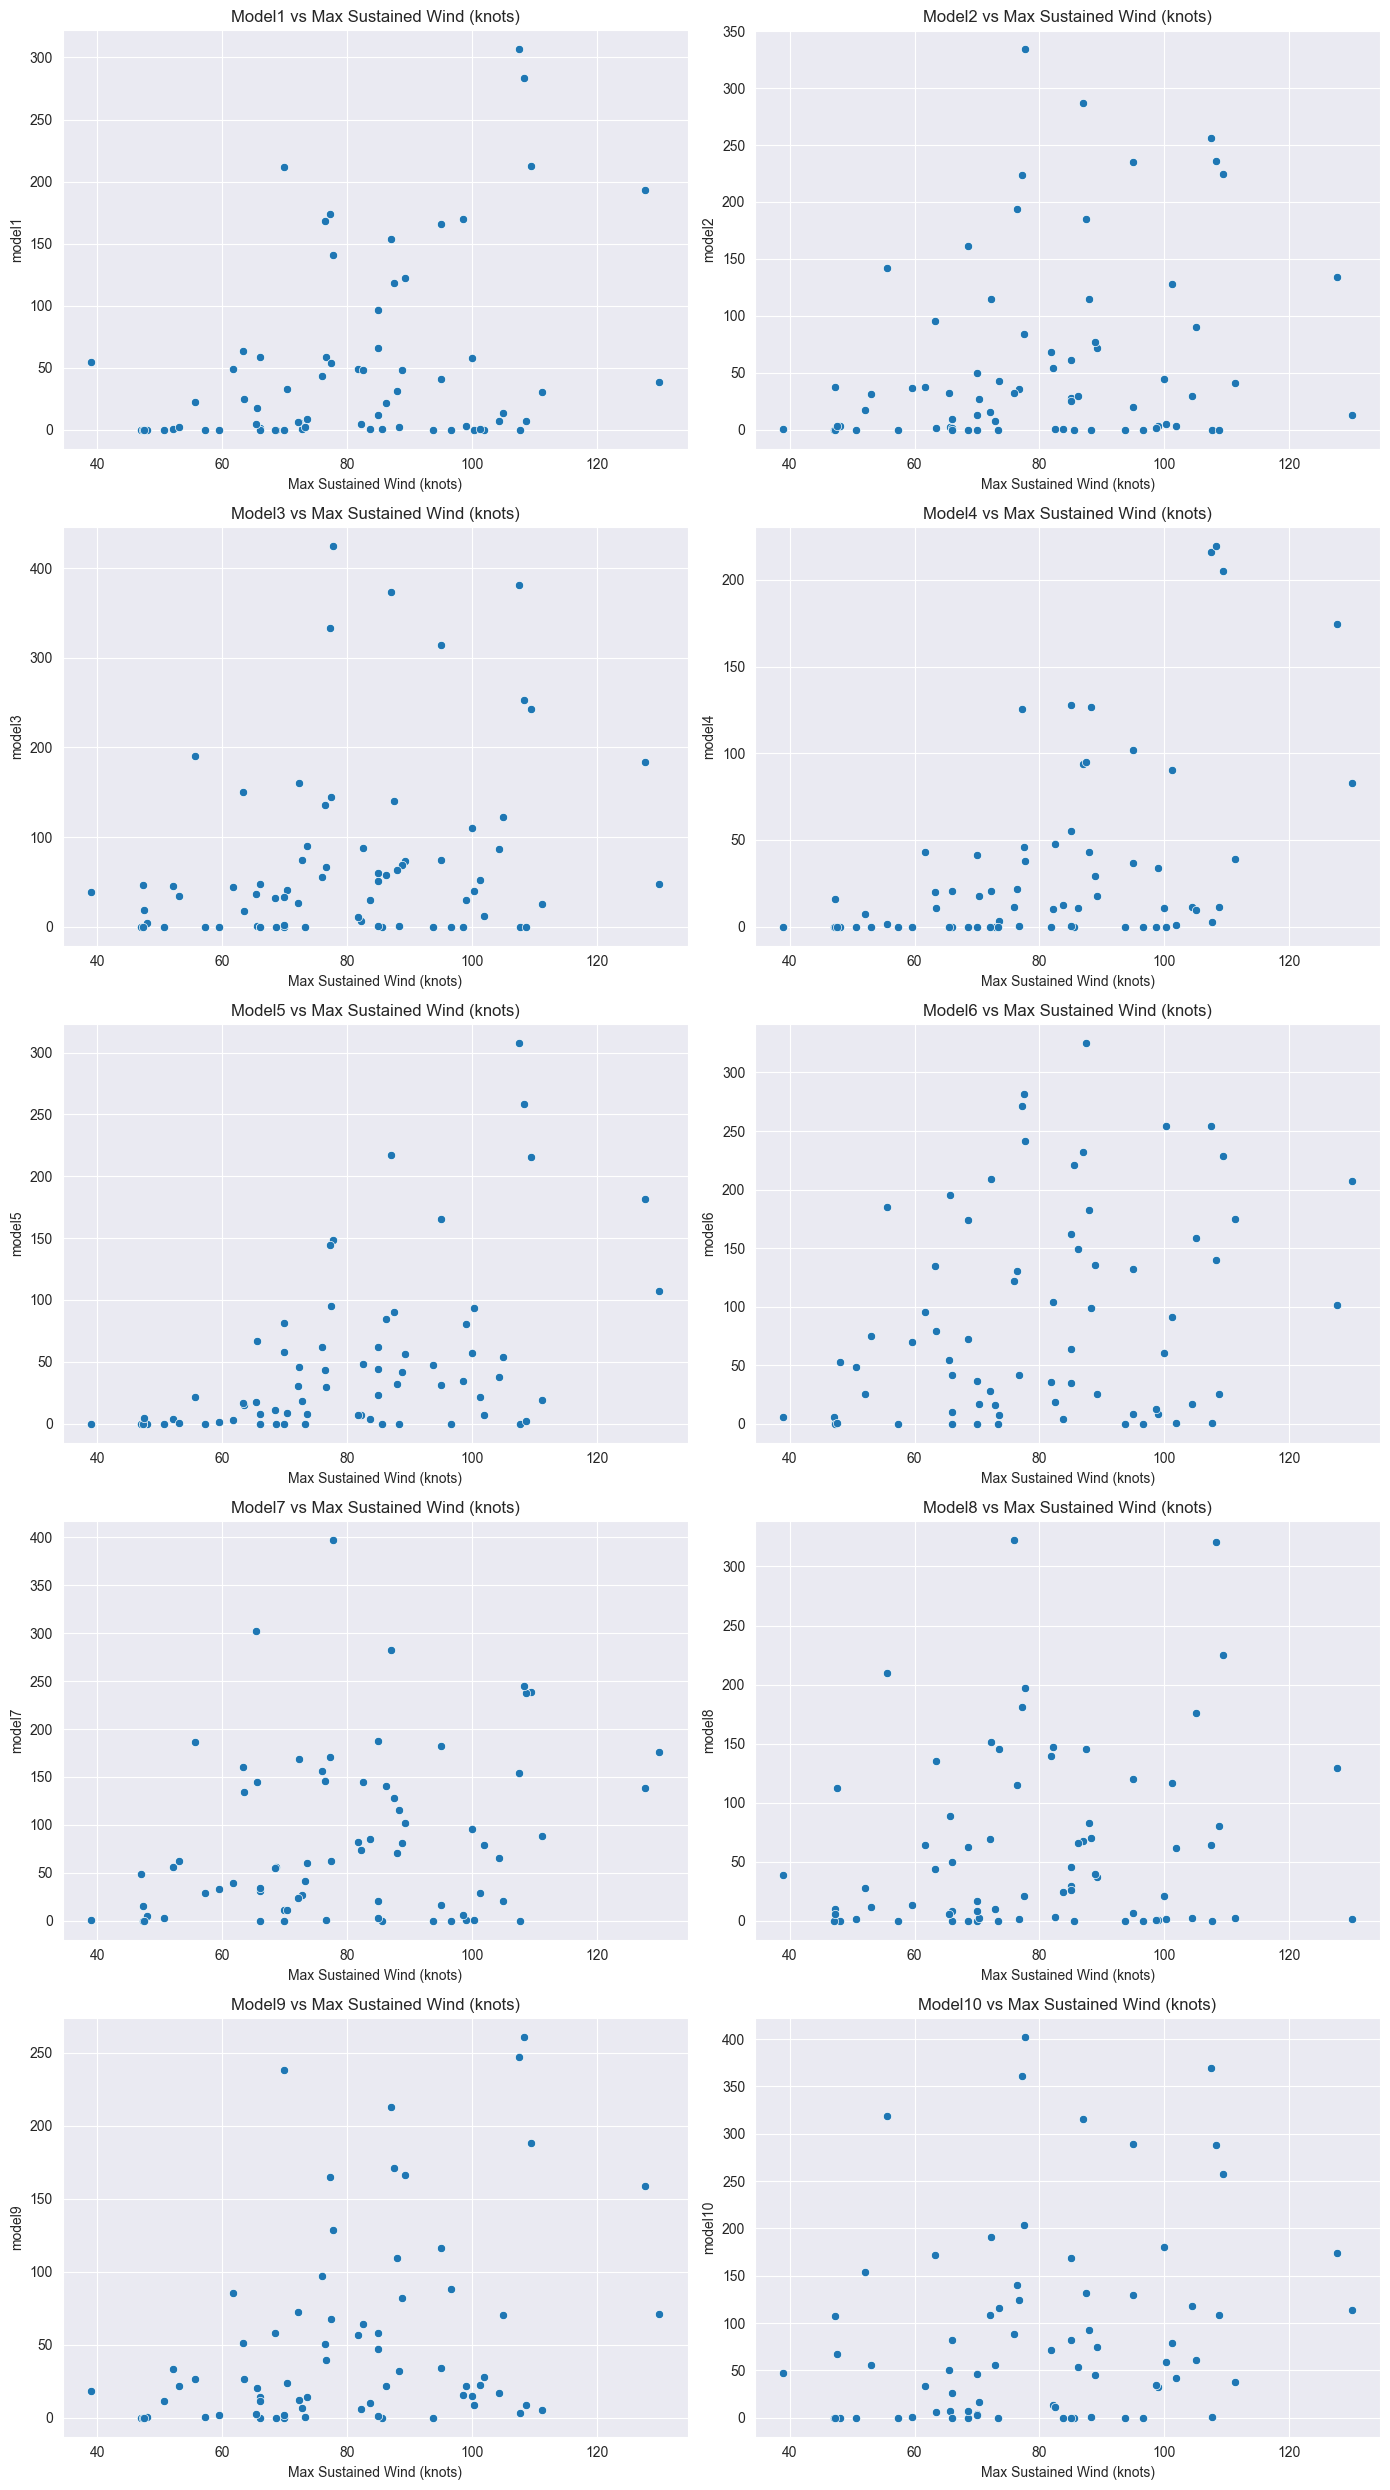

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# List of model columns to plot on x-axis
model_columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Example list

n = len(model_columns)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()  # Flatten in case it's a 2D array

for i, model_n in enumerate(model_columns):
    sns.scatterplot(data=df, y=f"model{model_n}", x='maximum_sustained_wind_knots_mean', ax=axes[i])
    axes[i].set_title(f'Model{model_n} vs Max Sustained Wind (knots)')
    axes[i].set_ylabel(f"model{model_n}")
    axes[i].set_xlabel('Max Sustained Wind (knots)')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Calculate Mean of Models. Also winsorize the mean to avoid outliers

In [80]:
model_cols = [col for col in df.columns if col.startswith('model')]
df['mean_model'] = df[model_cols].mean(axis=1)

In [81]:
df['mean_model_winsor'] = np.clip(df['mean_model'], 0, 400)

# Calculate Monte Carlo Estimate. Also winsorize the estimate to avoid outliers

In [82]:
import numpy as np

# Set seed for reproducibility
seed = 69
np.random.seed(seed)

# Extract posterior samples (from column 13 onward)
posterior_samples = df.iloc[:, 13:].values

# Number of draws per hurricane
n_draws = 1000000

# Monte Carlo simulation: draw `n_draws` samples with replacement per row, then average
monte_carlo_means = np.array([
    np.mean(np.random.choice(row, size=n_draws, replace=True))
    for row in posterior_samples
])

# Store in DataFrame
df['monte_carlo_estimate'] = monte_carlo_means

In [83]:
df['monte_carlo_estimate_winsor'] = np.clip(df['monte_carlo_estimate'], 0, 350)

# Visualize the mean and monte carlo estimate against a input feature

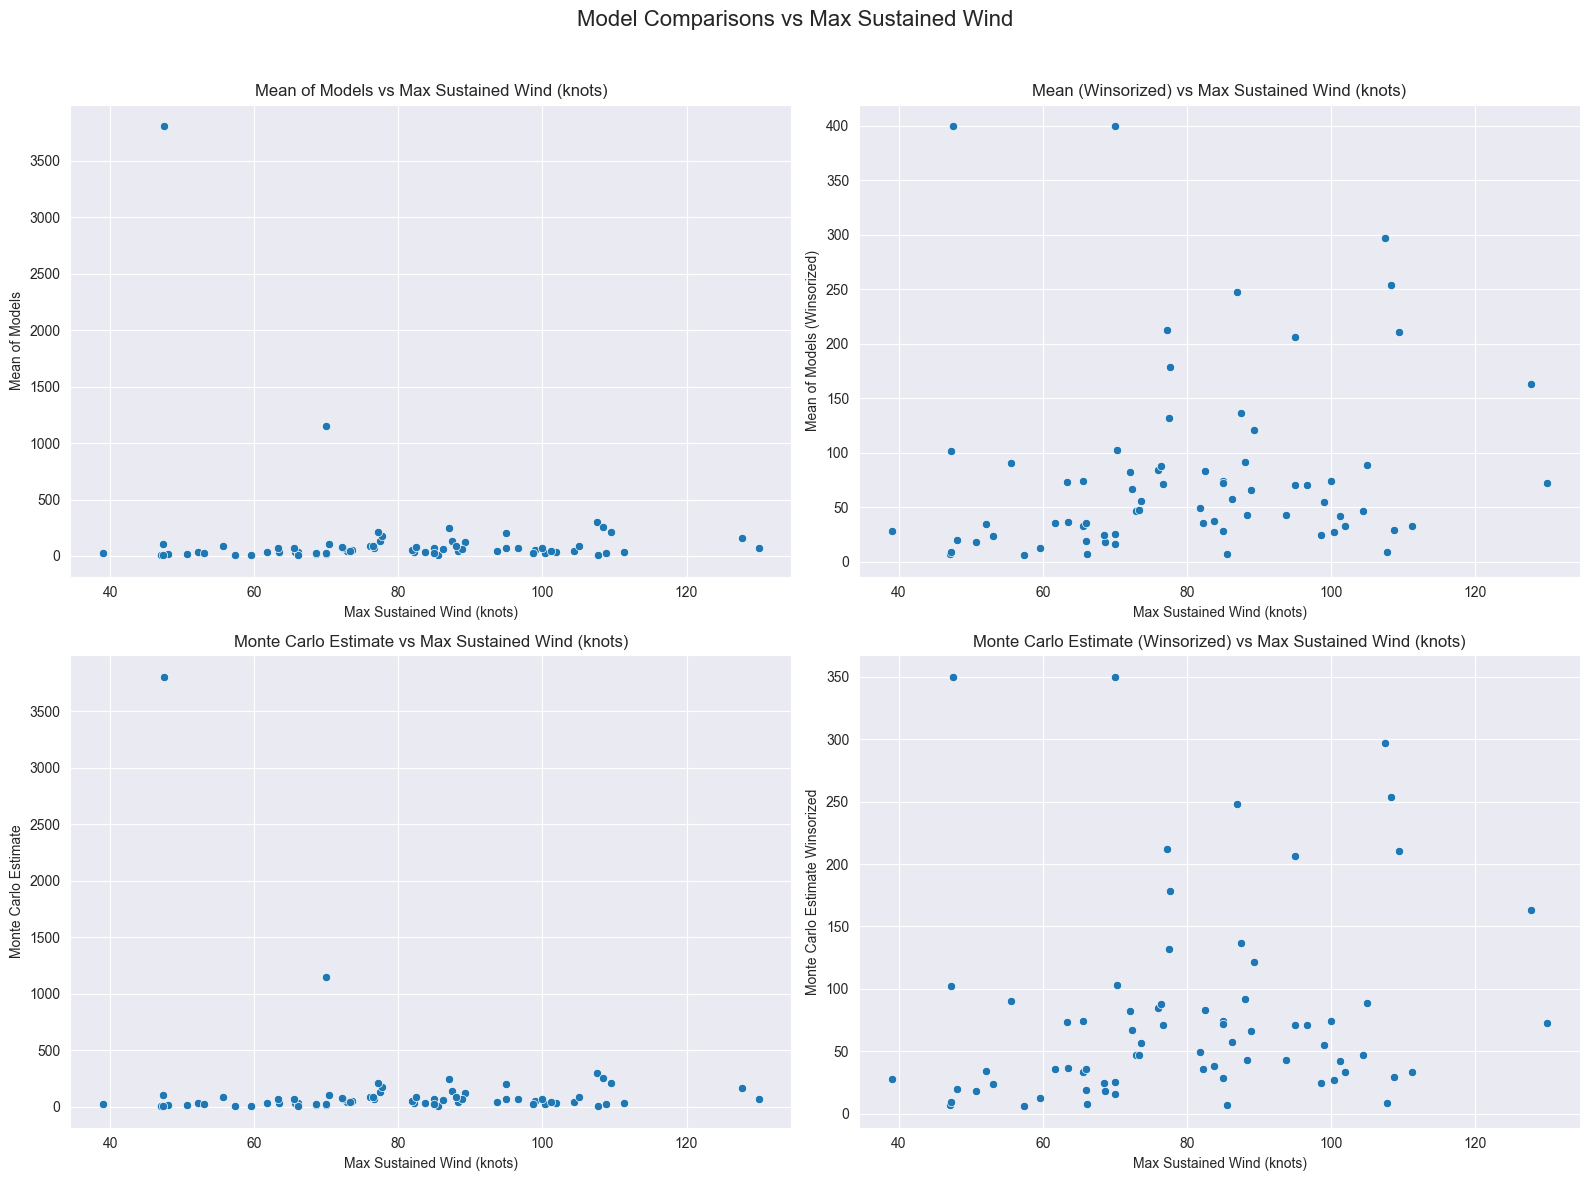

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Comparisons vs Max Sustained Wind', fontsize=16)

# Plot 1: Mean of Models
sns.scatterplot(data=df, y='mean_model', x='maximum_sustained_wind_knots_mean', ax=axes[0, 0])
axes[0, 0].set_title('Mean of Models vs Max Sustained Wind (knots)')
axes[0, 0].set_ylabel('Mean of Models')
axes[0, 0].set_xlabel('Max Sustained Wind (knots)')

# Plot 2: Mean of Models Winsorized
sns.scatterplot(data=df, y='mean_model_winsor', x='maximum_sustained_wind_knots_mean', ax=axes[0, 1])
axes[0, 1].set_title('Mean (Winsorized) vs Max Sustained Wind (knots)')
axes[0, 1].set_ylabel('Mean of Models (Winsorized)')
axes[0, 1].set_xlabel('Max Sustained Wind (knots)')

# Plot 3: Monte Carlo Estimate
sns.scatterplot(data=df, y='monte_carlo_estimate', x='maximum_sustained_wind_knots_mean', ax=axes[1, 0])
axes[1, 0].set_title('Monte Carlo Estimate vs Max Sustained Wind (knots)')
axes[1, 0].set_ylabel('Monte Carlo Estimate')
axes[1, 0].set_xlabel('Max Sustained Wind (knots)')
axes[1, 0].grid(True)

# Plot 4: Monte Carlo Estimate Winsorized
sns.scatterplot(data=df, y='monte_carlo_estimate_winsor', x='maximum_sustained_wind_knots_mean', ax=axes[1, 1])
axes[1, 1].set_title('Monte Carlo Estimate (Winsorized) vs Max Sustained Wind (knots)')
axes[1, 1].set_ylabel('Monte Carlo Estimate Winsorized')
axes[1, 1].set_xlabel('Max Sustained Wind (knots)')
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


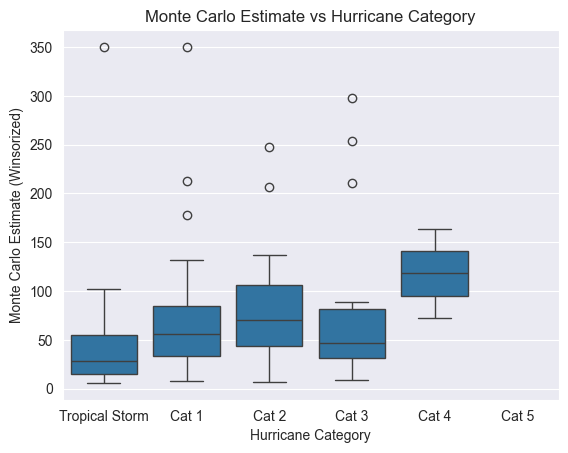

In [85]:
df['wind_bin'] = pd.cut(df['maximum_sustained_wind_knots_mean'], bins=[0, 64, 83, 95, 113, 137, np.inf],
                        labels=["Tropical Storm", "Cat 1", "Cat 2", "Cat 3", "Cat 4", "Cat 5"])

sns.boxplot(data=df, x='wind_bin', y='monte_carlo_estimate_winsor')
plt.title('Monte Carlo Estimate vs Hurricane Category')
plt.xlabel('Hurricane Category')
plt.ylabel('Monte Carlo Estimate (Winsorized)')
plt.show()

# Training Start

In [86]:
in_features = [
    'maximum_sustained_wind_knots_max',
    'maximum_sustained_wind_knots_mean',
    'central_pressure_mb_min',
    'central_pressure_mb_mean',
    'radius_of_max_wind_nm_max',
    'radius_of_max_wind_nm_mean']

output_feature = "monte_carlo_estimate_winsor"

In [89]:
import pandas as pd
import numpy as np

# Define a dictionary to store results
results = {
    "Model": [],
    "MAE": [],
    "R2": [],
    "Adjusted R2": [],
    "MAPE (%)": []
}

# Function to log and store results (accepts lists of metrics)
def log_results(model_name, mae_list, r2_list, adj_r2_list, mape_list):
    results["Model"].append(model_name)
    results["MAE"].append(round(np.mean(mae_list), 2))
    results["R2"].append(round(np.mean(r2_list), 3))
    results["Adjusted R2"].append(round(np.mean(adj_r2_list), 3))
    results["MAPE (%)"].append(f"{round(np.mean(mape_list) * 100, 2)}%")  # Convert MAPE to %

# Display all results
def display_results_table():
    df_results = pd.DataFrame(results)
    print("\nModel Performance Summary:")
    display(df_results)

# Display one model's result
def print_individual_result(model_name):
    if model_name in results["Model"]:
        idx = results["Model"].index(model_name)
        print(f"\n🔍 Results for {model_name}:")
        print(f"MAE         : {results['MAE'][idx]}")
        print(f"R2          : {results['R2'][idx]}")
        print(f"Adjusted R2 : {results['Adjusted R2'][idx]}")
        print(f"MAPE        : {results['MAPE (%)'][idx]}")
    else:
        print(f"Model '{model_name}' not found in results.")

# Ridge Regression

In [90]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = df[in_features]
y = df["mean_model_winsor"]

mae_list, r2_list, adj_r2_list, mape_list = [], [], [], []
n = len(y)
p = X.shape[1]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - p - 1)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    mae_list.append(mae)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)
    mape_list.append(mape)

log_results("Ridge Regression", mae_list, r2_list, adj_r2_list, mape_list)

# Linear Regression

In [91]:
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = df[in_features]
y = df[output_feature]

mae_list, r2_list, adj_r2_list, mape_list = [], [], [], []
n = len(y)
p = X.shape[1]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - p - 1)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    mae_list.append(mae)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)
    mape_list.append(mape)

log_results("Linear Regression", mae_list, r2_list, adj_r2_list, mape_list)

# Random Forest Regression

In [92]:
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = df[in_features]
y = df[output_feature]

mae_list, r2_list, adj_r2_list, mape_list = [], [], [], []
n = len(y)
p = X.shape[1]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - p - 1)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    mae_list.append(mae)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)
    mape_list.append(mape)


log_results("Random Forest Regression", mae_list, r2_list, adj_r2_list, mape_list)

# MLP Regression

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare data
X = torch.tensor(df[in_features].values, dtype=torch.float32).to(device)
y = torch.tensor(df["mean_model_winsor"].values, dtype=torch.float32).view(-1, 1).to(device)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

mae_list, r2_list, adj_r2_list, mape_list = [], [], [], []
p = X.shape[1]

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = MLP(input_dim=p).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training
    model.train()
    for epoch in range(500):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        preds = model(X_test).cpu().numpy().flatten()
        y_true = y_test.cpu().numpy().flatten()

    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - p - 1)
    mape = mean_absolute_percentage_error(y_true, preds)

    mae_list.append(mae)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)
    mape_list.append(mape)


log_results("MLP Regressor", mae_list, r2_list, adj_r2_list, mape_list)

Using device: cpu


# XGBoost Regression

In [94]:
from xgboost import XGBRegressor

kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = df[in_features]
y = df["mean_model_winsor"]

mae_list, r2_list, adj_r2_list, mape_list = [], [], [], []
n = len(y)
p = X.shape[1]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - p - 1)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    mae_list.append(mae)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)
    mape_list.append(mape)


log_results("XGBoost Regressor", mae_list, r2_list, adj_r2_list, mape_list)

In [95]:
display_results_table()


Model Performance Summary:


,Model,MAE,R2,Adjusted R2,MAPE (%)
0,Ridge Regression,38.12,0.429,0.227,118.41%
1,Linear Regression,35.27,0.493,0.314,114.67%
2,Random Forest Regression,41.86,0.270,0.012,83.12%
3,MLP Regressor,55.39,-0.893,-1.561,100.04%
4,XGBoost Regressor,47.51,0.167,-0.127,85.28%
